In [70]:
import glob
import shutil

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits


# Strong Lensing Cutouts for Lens Painting

You can find the data on Datalabs at

    /media/home/team_workspaces/Euclid-Consortium/data/strong_lensing/external_targets_pipeline/latest/cutouts/fits
    
Divided into subfolders by tile.

The target cutouts are LRG galaxies selected by Karina using SDSS and DESI spectroscopy and visual inspection. 

In [71]:
# glob.glob('/media/home/team_workspaces/Euclid-Consortium/data/strong_lensing/external_targets_pipeline/latest/cutouts/fits/*')

In [72]:
cutout_locs = glob.glob('/media/home/team_workspaces/Euclid-Consortium/data/strong_lensing/external_targets_pipeline/latest/cutouts/fits/101541378/*.fits')
cutout_locs[:2]

['/media/home/team_workspaces/Euclid-Consortium/data/strong_lensing/external_targets_pipeline/latest/cutouts/fits/101541378/1237651736280760485.fits',
 '/media/home/team_workspaces/Euclid-Consortium/data/strong_lensing/external_targets_pipeline/latest/cutouts/fits/101541378/EUC_2719_DESI-sel.fits']

## Open an example FITS file

Each FITS has extensions with the data for all bands.
For each band, we store the flux, the PSF, and the RMS (in that order).

Currently, the order is like so:

In [73]:
# fits_to_test = '/media/home/team_workspaces/Euclid-Consortium/data/strong_lensing/external_targets_pipeline/latest/cutouts/fits/101544256/EUC_4287_DESI-sel.fits'
fits_to_test = cutout_locs[0]

hdu = fits.open(fits_to_test)

In [74]:
hdu.info()

Filename: /media/home/team_workspaces/Euclid-Consortium/data/strong_lensing/external_targets_pipeline/latest/cutouts/fits/101541378/1237651736280760485.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   ()      
  1  VIS_FLUX      1 ImageHDU        69   (200, 200)   float32   
  2  VIS_PSF       1 ImageHDU         9   (19, 19)   float32   
  3  VIS_RMS       1 ImageHDU         8   (200, 200)   float32   
  4  NIR_Y_FLUX    1 ImageHDU        60   (200, 200)   float32   
  5  NIR_Y_PSF     1 ImageHDU         9   (33, 33)   float32   
  6  NIR_Y_RMS     1 ImageHDU         8   (200, 200)   float32   
  7  NIR_J_FLUX    1 ImageHDU        60   (200, 200)   float32   
  8  NIR_J_PSF     1 ImageHDU         9   (33, 33)   float32   
  9  NIR_J_RMS     1 ImageHDU         8   (200, 200)   float32   
 10  NIR_H_FLUX    1 ImageHDU        60   (200, 200)   float32   
 11  NIR_H_PSF     1 ImageHDU         9   (33, 33)   float32   
 12  NIR_H_R

The primary HDU has a header has these `EXT_N` fields. You can use this to decide which extensions to open.

The primary HDU is itself empty - it's only the header.

In [75]:
hdu[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
EXT_1   = 'VIS_FLUX'           / Extension name for VIS flux                    
EXT_2   = 'VIS_PSF '           / Extension name for VIS PSF                     
EXT_3   = 'VIS_RMS '           / Extension name for VIS RMS                     
EXT_4   = 'NIR_Y_FLUX'         / Extension name for NIR_Y flux                  
EXT_5   = 'NIR_Y_PSF'          / Extension name for NIR_Y PSF                   
EXT_6   = 'NIR_Y_RMS'          / Extension name for NIR_Y RMS                   
EXT_7   = 'NIR_J_FLUX'         / Extension name for NIR_J flux                  
EXT_8   = 'NIR_J_PSF'          / Extension name for NIR_J PSF                   
EXT_9   = 'NIR_J_RMS'       

For all extensions (except the zeroth, which is empty) the `EXTNAME` card also describes which data is in that extension.

For FLUX and RMS extensions, the header includes a WCS file describing the sky position. Load it with

    from astropy.wcs import WCS
    wcs = WCS(header)
                

In [76]:
hdu[1].header  # header for the first extension, VIS flux

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  200                                                  
NAXIS2  =                  200                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
EQUINOX =        2000.00000000 / Mean equinox                                   
RADESYS = 'ICRS    '           / Equatorial coordinate system                   
CTYPE1  = 'RA---TAN'           / Right ascension, gnomonic projection           
CUNIT1  = 'deg     '           / Units of coordinate increment and value        
CRVAL1  =   1.503015045718E+02 / [deg] Coordinate value at reference point      
CRPIX1  =              -4725

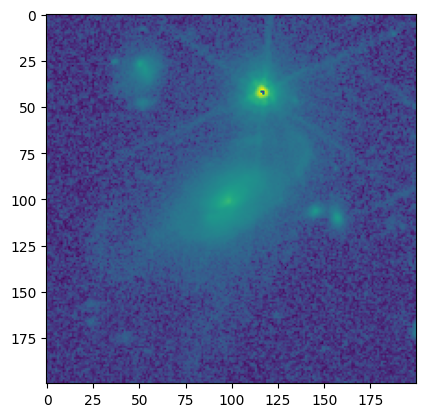

In [77]:
plt.imshow(np.arcsinh(500*hdu[1].data))  # vis flux
# (using an arcsinh stretch to show the details better on this plot)

The PSF should be centered within 1 pixel. 

It will typically not be perfectly centered visually. This is because the PSF image has very few cells/pixels (e.g. 21x21 cells/pixels below) and so the central PSF pixel is offset from the precise/nominal image center (e.g. below, the PSF center is at pixel/cell 10 below, not the exact center of the array at 10.5, because 10.5 is not a pixel/cell). 

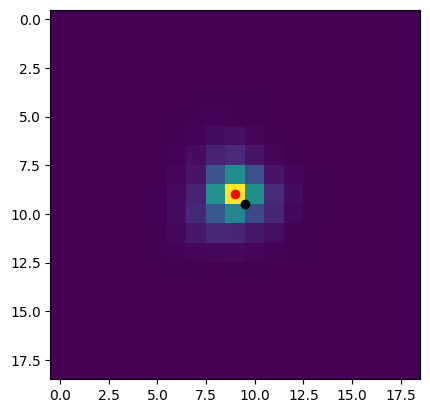

In [78]:
plt.imshow(hdu[2].data)  # vis psf, will be centered within 1 pixel


x_c_exact, y_c_exact = hdu[2].data.shape[0] // 2, hdu[2].data.shape[1] // 2
x_c, y_c = hdu[2].data.shape[0] / 2, hdu[2].data.shape[1] / 2

plt.scatter(x_c_exact, y_c_exact, color='r')
plt.scatter(x_c, y_c, color='k')

Unlike the flux and RMS extensions, the PSF does not have WCS in the header (in part because it is not actually on the sky).

In [79]:
hdu[2].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   19                                                  
NAXIS2  =                   19                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
FILTER  = 'VIS     '           / Euclid filter for PSF image                    
EXTNAME = 'VIS_PSF '           / extension name                                 

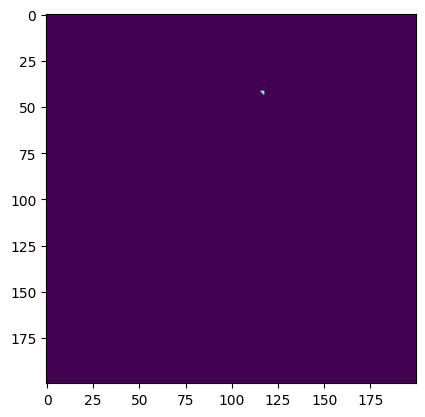

In [80]:
plt.imshow(hdu[3].data)  # vis rms

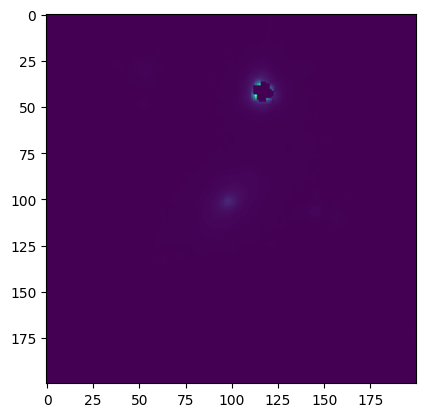

In [81]:
plt.imshow(hdu[4].data)  # nir y flux

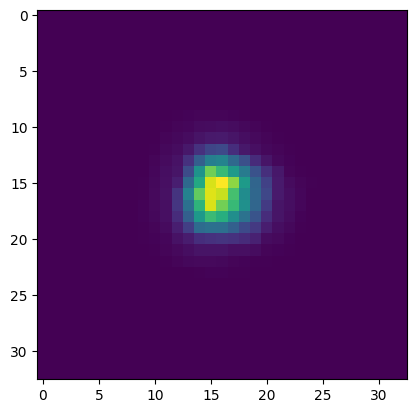

In [82]:
plt.imshow(hdu[5].data)  # nir y PSF

In [83]:
hdu[6].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  200                                                  
NAXIS2  =                  200                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
EXTNAME = 'NIR_Y_RMS'          / extension name                                 

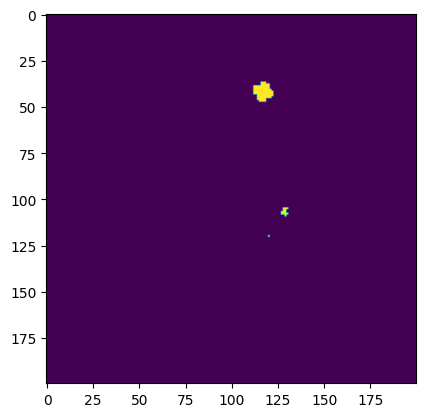

In [84]:
plt.imshow(hdu[6].data)  # nir y RMS (looks a little strange?)

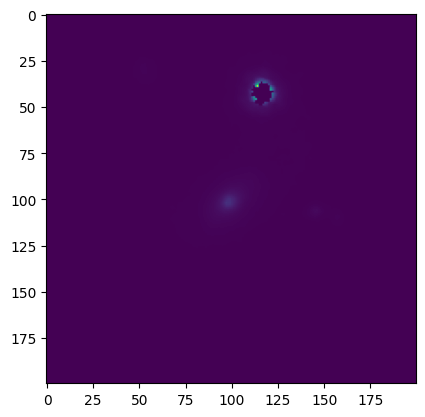

In [85]:
plt.imshow(hdu[7].data)  # nir J flux

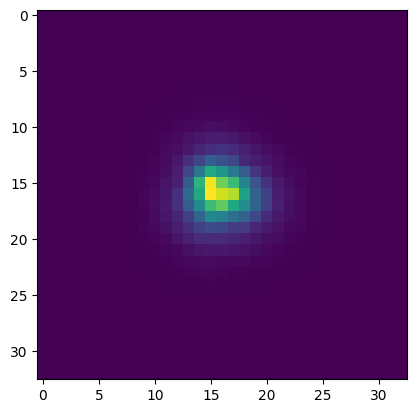

In [86]:
plt.imshow(hdu[8].data)  # nir J PSF

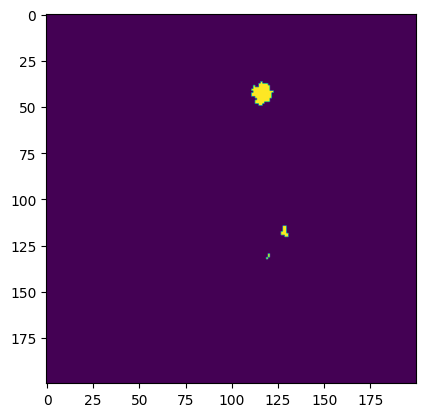

In [87]:
plt.imshow(hdu[9].data)  # NIR J RMS

In [88]:


fits_dir = '/media/home/team_workspaces/Euclid-Consortium/data/strong_lensing/external_targets_pipeline/latest/cutouts/fits/*/*.fits'

cutouts = glob.glob(fits_dir)
len(cutouts)


3830

In [89]:

# for cutout_loc in cutouts:
#     print(fits.getdata(cutout_loc, ext=4).shape)

In [90]:
assert False

AssertionError: 

In [ ]:
shutil.make_archive(
    '/media/home/team_workspaces/Euclid-Consortium/data/strong_lensing/external_targets_pipeline/latest/cutouts', 
    'zip', 
    root_dir='/media/home/team_workspaces/Euclid-Consortium/data/strong_lensing/external_targets_pipeline/latest/cutouts')